In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import re
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# My attempt on titnaic problem from Kaggle
# https://www.kaggle.com/competitions/titanic/overview
# with minimal/occaasional reference from:
# https://www.kaggle.com/code/startupsci/titanic-data-science-solutions
#
# Code to predict who survived in titanic sinking


2022-04-07 16:17:09.163536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-07 16:17:09.163573: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#Get Data
train_dataset = pd.read_csv("./train.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)
test_dataset = pd.read_csv("./test.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)

#Check Columns/Features
print(train_dataset.columns.values)
print(test_dataset.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [88]:
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,A,B,C,D,E,F,G,T,NumOfCabin,TicketNum
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,21171.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,17599.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,3101282.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,113803.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,373450.0


In [5]:
#Check info, eg. which have NaN (In this case Age, Cabin, Embarked)
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test_dataset.info() 
#Age, Fare, Cabin


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
train_dataset.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [276]:
#Data "cleaning"(?) 
# Get new data from existing data 
# fill NaN data

train_dataset = pd.read_csv("./train.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)
test_dataset = pd.read_csv("./test.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)

combine = [train_dataset,test_dataset]

for dataset in combine:
    dataset["FamSize"]=dataset["SibSp"]+dataset["Parch"]
    dataset["Alone"] =  (dataset["FamSize"]  == 0)

    dataset["Age"] = dataset["Age"].fillna(value=-1)
    dataset["Embarked"] = dataset["Embarked"].fillna(value="-")
    dataset["Fare"] = dataset["Fare"].fillna(value=-1)

    # Update Cabin Data
    dataset["Cabin"] =  dataset["Cabin"].fillna(value=0)
    dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')
    print(dataset["CabinGroup"].unique())
    Cabingroup = ["A", "B", "C", "D", "E", "F", "G", "T"]
    for i in Cabingroup:
        dataset[i] =     dataset["CabinGroup"].str.count(i)
        dataset[i] =     dataset[i].fillna(value=0)
        #print(dataset[[i, "Survived"]].groupby([i], as_index=False).mean().sort_values(by='Survived', ascending=False))

    dataset["NumOfCabin"] = dataset["CabinGroup"].str.split(" ").str.len()
    dataset["NumOfCabin"] = dataset["NumOfCabin"].fillna(value=0)

    #dataset.loc[dataset['Ticket'].str.split(" ").str.len() == 1, 'TicketNum'] = dataset["Ticket"].str.replace('[a-zA-Z]', '')
    #dataset.loc[dataset['Ticket'].str.split(" ").str.len() > 1, 'TicketNum'] 
    dataset['TicketNum']= dataset["Ticket"].str.split(" ").str[-1]

    print(dataset[dataset['TicketNum'].isna()].Ticket)
    dataset ['TicketNum'] = pd.to_numeric(dataset['TicketNum'], errors='coerce')
    dataset ['TicketNum'] = dataset['TicketNum'].replace(np.nan, -1, regex=True)

    #Name
    #dataset.loc[dataset['Name'].str.split(",").str.len() == 2, 'First Name'] = dataset['Name'].str.split(",").str[0]
    dataset["First Name"] = dataset['Name'].str.split(",").str[0]
    dataset["Last Name"] = dataset['Name'].str.split(",").str[-1].str.split(".").str[-1].str.split(" ").str[-1]
    #dataset.loc[dataset['Name'].str.split(",").str.len() == 2, 'Last Name'] = dataset['Name'].str.split(",").str[-1].str.split(".").str[-1]
    dataset.loc[dataset['Name'].str.split(",").str.len() == 2, 'Title'] = dataset['Name'].str.split(",").str[-1].str.split(".").str[0]
    dataset["Title"] = dataset["Title"].replace(" Ms", " Miss")

[nan 'C' 'E' 'G' 'D' 'A' 'C C C' 'B' 'F' 'F G' 'D D' 'B B' 'F E' 'C C'
 'B B B B' 'T' 'B B B']
Series([], Name: Ticket, dtype: object)
[nan 'B' 'E' 'B B B B' 'A' 'C' 'D' 'C C C' 'F G' 'C C' 'F' 'G' 'B B' 'F E'
 'B B B' 'D D' 'E E']
Series([], Name: Ticket, dtype: object)


/tmp/ipykernel_487684/2569595822.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')
/tmp/ipykernel_487684/2569595822.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')


    F  Survived
20  U  1.000000
16  Q  1.000000
26  v  0.500000
10  K  0.500000
6   G  0.487805
7   H  0.478261
21  V  0.461538
13  N  0.448276
3   D  0.435897
14  O  0.434783
0   A  0.431373
23  Y  0.428571
5   F  0.419355
12  M  0.405405
22  W  0.393939
17  R  0.390244
9   J  0.366667
18  S  0.348837
8   I  0.333333
15  P  0.319149
11  L  0.312500
1   B  0.305556
19  T  0.300000
2   C  0.289855
4   E  0.250000
25  d  0.250000
24  Z  0.000000
    L  Survived
7   F  0.551724
0   "  0.500000
18  Q  0.500000
10  I  0.500000
26  Z  0.500000
8   G  0.486486
23  V  0.450000
13  L  0.447368
14  M  0.421687
17  P  0.419355
6   E  0.409836
5   D  0.400000
16  O  0.400000
24  W  0.391304
11  J  0.386364
1   (  0.375000
9   H  0.370968
20  S  0.350000
19  R  0.342857
4   C  0.342857
2   A  0.313953
12  K  0.307692
21  T  0.296296
3   B  0.256410
15  N  0.187500
22  U  0.000000
25  Y  0.000000


/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


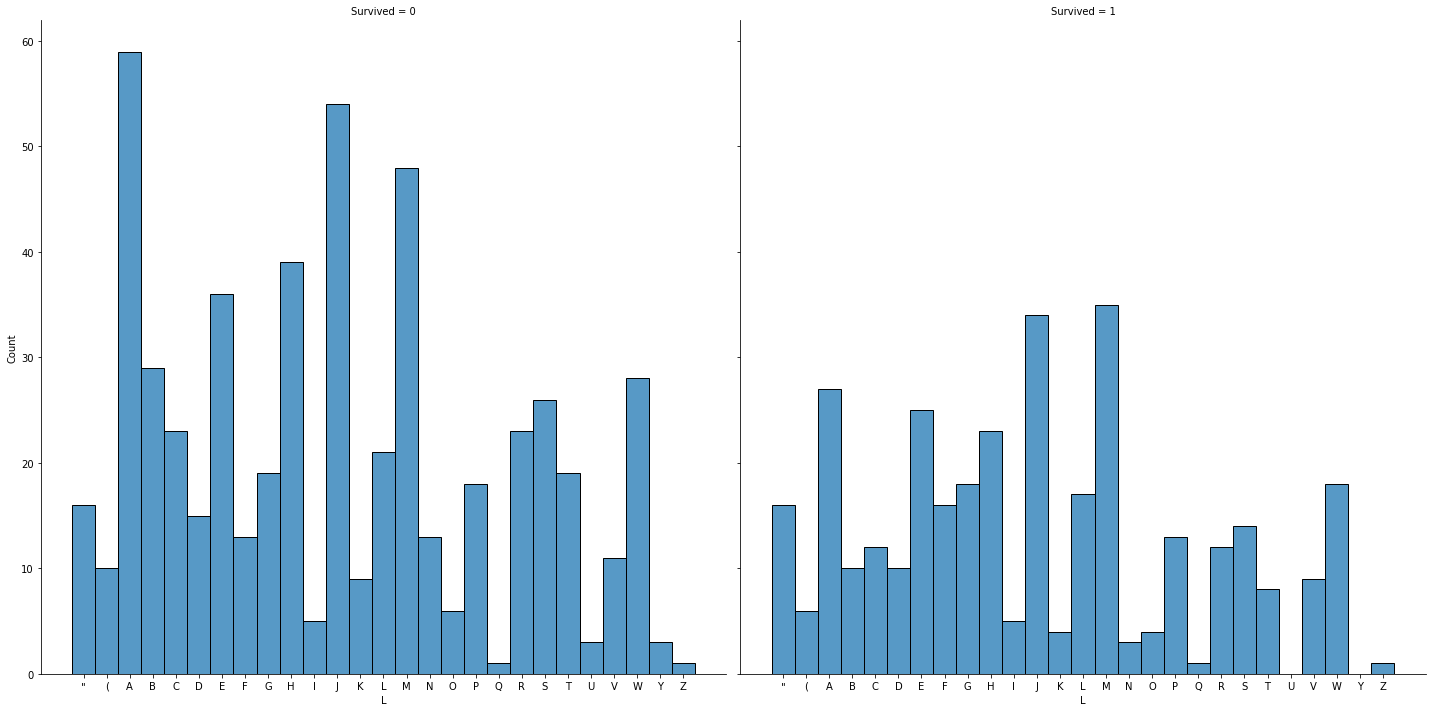

/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


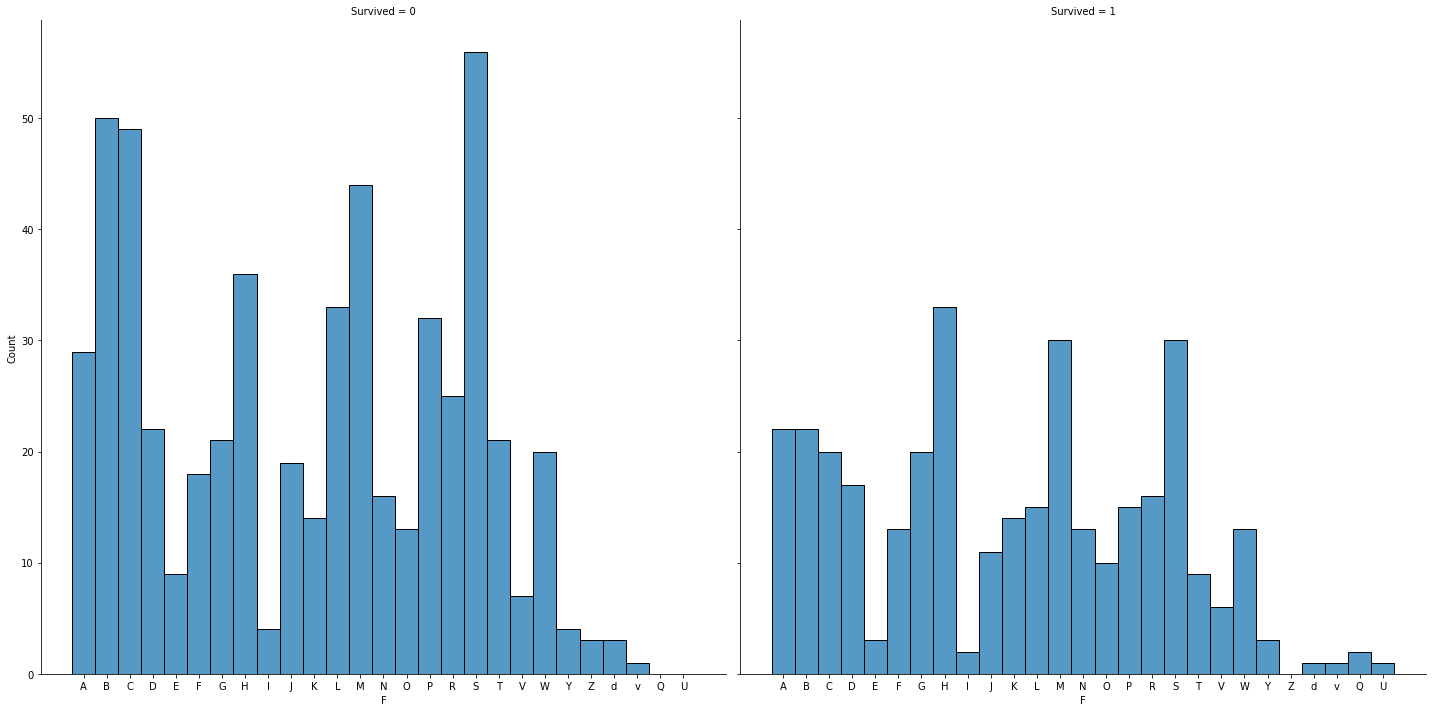

In [277]:

#Try to see any correlation with the initials and survival rate, -> not really, only see how common names are generally

#train_dataset.head()
#train_dataset[['First Name', "Survived"]].groupby(['First Name'])["Survived"].count().reset_index(name='Survived').sort_values(['Survived'], ascending=False)
#train_dataset.loc[train_dataset['Survived'] == 1, 'X'] = train_dataset['First Name'].str[0]
#train_dataset.loc[train_dataset['Survived'] == 1, 'Y'] = train_dataset['Last Name'].str[0]
#train_dataset.loc[train_dataset['Survived'] == 0, 'X0'] = train_dataset['First Name'].str[0]
#train_dataset.loc[train_dataset['Survived'] == 0, 'Y0'] = train_dataset['Last Name'].str[0]

train_dataset["F"] =  train_dataset['First Name'].str[0].sort_values().reset_index(drop=True)
train_dataset["L"] =  train_dataset['Last Name'].str[0].sort_values().reset_index(drop=True)
with pd.option_context('display.max_rows', None,):
   print(train_dataset[['F', "Survived"]].groupby(["F"], as_index=False).mean().sort_values(by='Survived', ascending=False).head(100))
   print(train_dataset[['L', "Survived"]].groupby(["L"], as_index=False).mean().sort_values(by='Survived', ascending=False).head(100))

#train_dataset["F"] = train_dataset[['F', "Survived"]].groupby(["F"], as_index=False).mean().sort_values(by='Survived', ascending=False)

g = sns.FacetGrid(train_dataset,col="Survived",size=10)
g.map(sns.histplot, "L")
plt.show()

g = sns.FacetGrid(train_dataset,col="Survived",size=10)
g.map(sns.histplot, "F")
plt.show()
#   print(train_dataset[['X', "Survived"]].groupby(["X"], as_index=False).count().sort_values(by='X', ascending=False).head(100))
#   print(train_dataset[['X0', "Survived"]].groupby(["X0"], as_index=False).count().sort_values(by='X0', ascending=False).head(100))
#   print(train_dataset[['Y', "Survived"]].groupby(["Y"], as_index=False).count().sort_values(by='Survived', ascending=False).head(100))
#   print(train_dataset[['Y0', "Survived"]].groupby(["Y0"], as_index=False).count().sort_values(by='Survived', ascending=False).head(100))
#train_dataset['X']
#train_dataset['First Name'].nunique()
#train_dataset[['First Name', "Survived"]].groupby(['Survived'], as_index=False).mean().sort_values(by='Survived', ascending=False)
#train_dataset[['First Name', "Survived"]].groupby(['Survived'], as_index=False).count()

#train_dataset[["Last Name", "Survived"]].groupby(["Last Name"], as_index=False).mean().sort_values(by='Survived', ascending=False)




In [278]:
for dataset in combine:
    print(dataset.columns)
    dataset = dataset.drop(["Name","Cabin","CabinGroup","Ticket","PassengerId"],axis=1)
    dataset.info()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamSize', 'Alone',
       'CabinGroup', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'NumOfCabin',
       'TicketNum', 'First Name', 'Last Name', 'Title', 'L'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    object 
 8   FamSize     891 non-null    int64  
 9   Alone       891 non-null    bool   
 10  A           891 non-null    float64
 11  B           891 non-null    float64
 12  C      

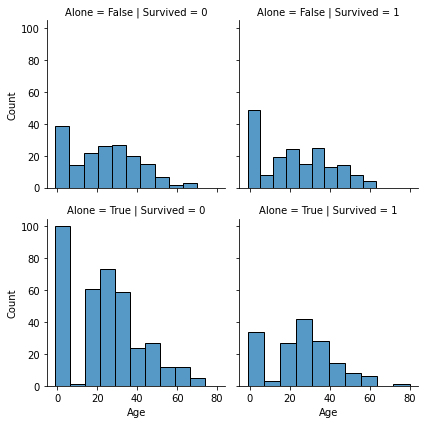

In [94]:

g = sns.FacetGrid(train_dataset, col='Survived',row='Alone')
g.map(sns.histplot, "Age",bins=10)
plt.show()

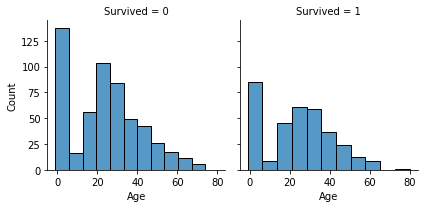

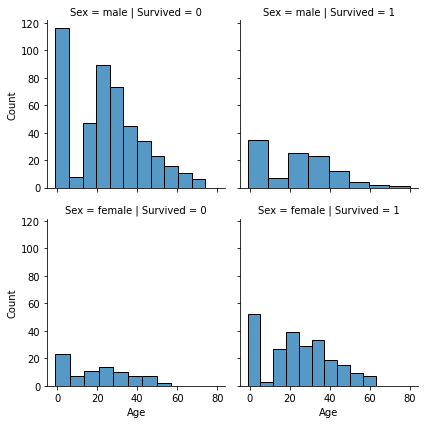

In [81]:
#Visualize some data to get some idea
g = sns.FacetGrid(train_dataset, col='Survived')
g.map(sns.histplot, "Age")
plt.show()

g = sns.FacetGrid(train_dataset, col='Survived',row='Sex')
g.map(sns.histplot, "Age")
plt.show()

/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


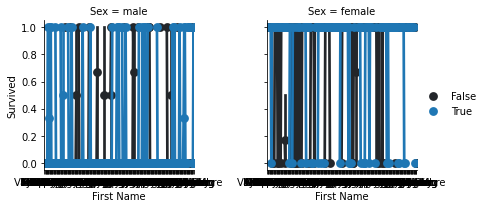

In [192]:
g = sns.FacetGrid(train_dataset, col="Sex")
g.map(sns.pointplot, 'First Name',"Survived", "Alone")#, order=["S","Q","C","-"],hue_order=["male","female"])
g.add_legend()
plt.show()


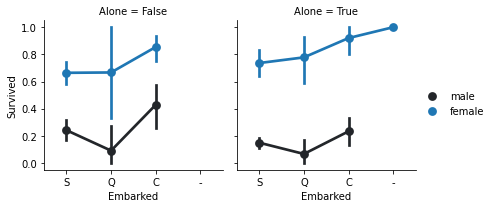

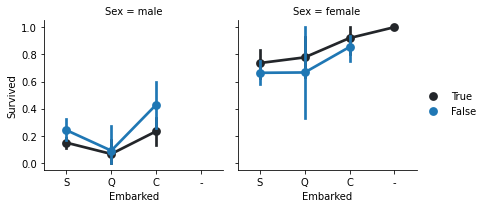

In [73]:
g = sns.FacetGrid(train_dataset, col="Alone")
g.map(sns.pointplot, 'Embarked',"Survived", "Sex", order=["S","Q","C","-"],hue_order=["male","female"])
g.add_legend()
plt.show()

g = sns.FacetGrid(train_dataset, col="Sex")
g.map(sns.pointplot, 'Embarked',"Survived", "Alone", order=["S","Q","C","-"],hue_order=[True,False])
g.add_legend()
plt.show()
#Somehow if youre a man and youre alone, you die more easily
#but if youre a woman and youre alone, you more likely to survived?


/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


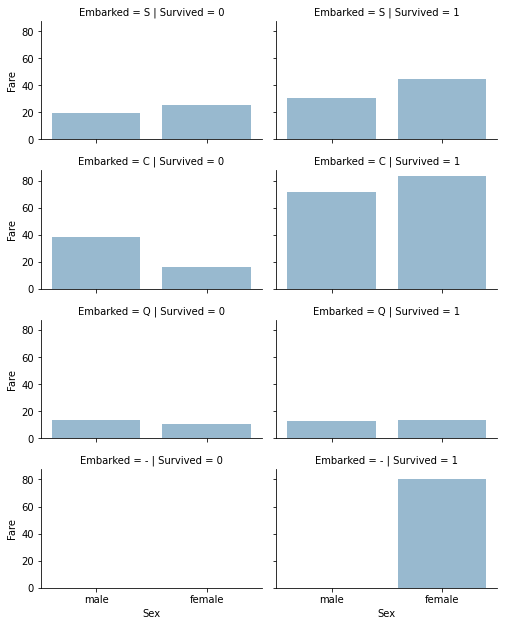

In [96]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_dataset, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None,order=["male","female"])
grid.add_legend()

/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


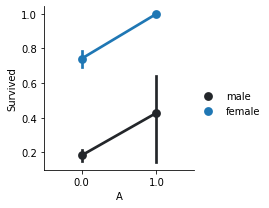

/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


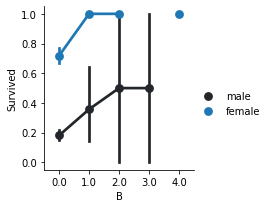

/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


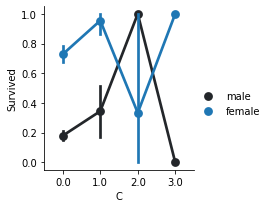

/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


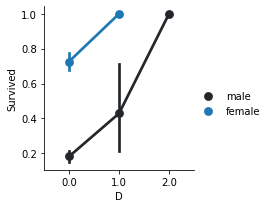

/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


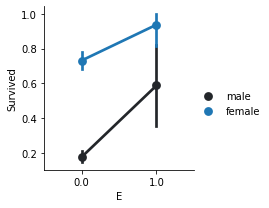

/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


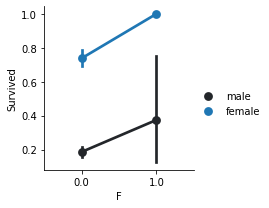

/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


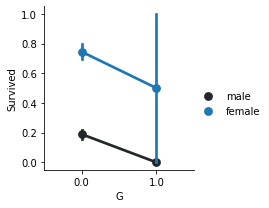

/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


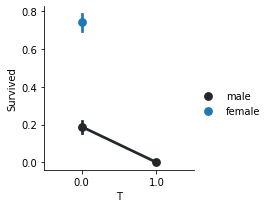

In [112]:
#g = sns.FacetGrid(train_dataset, col="Sex")
#g.map(sns.pointplot, 'A',"Survived", "Alone" )
#g.add_legend()
#plt.show()
#g = sns.FacetGrid(train_dataset, col="Sex")
#g.map(sns.pointplot, 'B',"Survived", "Alone" )
#g.add_legend()
#plt.show()
#g = sns.FacetGrid(train_dataset, col="Sex")
#g.map(sns.pointplot, 'C',"Survived", "Alone" )
#g.add_legend()
#plt.show()
for i in Cabingroup:
    g = sns.FacetGrid(train_dataset)
    g.map(sns.pointplot, i,"Survived", "Sex" )
    g.add_legend()
    plt.show()


In [1]:
##checkdat = ["FamSize", "CabinGroup", "#", "Alone"]
##for i in checkdat:
##    print(train_dataset[[i, "Survived"]].groupby([i], as_index=False).mean().sort_values(by='Survived', ascending=False))
##
##for i in test_dataset.columns.values:
##    print(train_dataset[[i, "Survived"]].groupby([i], as_index=False).mean().sort_values(by='Survived', ascending=False))
##
##for i in Cabingroup:
##    print(train_dataset[[i, "Survived"]].groupby([i], as_index=False).mean().sort_values(by='Survived', ascending=False))

In [4]:

train_dataset.info()
#train_dataset["GivenName"] = train_dataset["Name"].str.split(",")[1]

#train_dataset["C"] = train_dataset["CabinGroup"].str.find("C")
#train_dataset["CabinGroup"] = train_dataset["CabinGroup"].apply(lambda x: [z for y in x for z in y.strip("'").lower().split()])
train_dataset = train_dataset.drop(["Name", "Ticket","Cabin","Last Name","First Name",'CabinGroup'], axis=1)

#train_dataset = train_dataset[["PassengerId","Survived","Pclass","Name","Sex","Age","SibSp","Parch","FamSize","Alone","Ticket","Fare","Cabin","Embarked","w/Cabin"]]
train_dataset = train_dataset[['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch','Fare',  'FamSize', "NumOfCabin", 'A', 'B','C', 'D', 'E', 'F', 'G', 'T','Embarked','Sex', '#','Alone']]
train_dataset.head(30)
#test_dataset.head(30)

#categorical_features = ["#", "Sex", "Embarked"]
#categorical_transformer = OneHotEncoder(handle_unknown="ignore")

train_dataset.head(30)
print(train_dataset.columns)
train_dataset.sample(frac=0.8).head(30)

#train_dataset = ct.fit_transform(train_dataset)
#train_dataset.head(30)


   FamSize  Survived
3        3  0.724138
2        2  0.578431
1        1  0.552795
6        6  0.333333
0        0  0.303538
4        4  0.200000
5        5  0.136364
7        7  0.000000
8       10  0.000000
   CabinGroup  Survived
4     B B B B  1.000000
9         D D  1.000000
12        F E  1.000000
11          F  0.777778
1           B  0.750000
8           D  0.750000
10          E  0.750000
2         B B  0.714286
5           C  0.607843
3       B B B  0.500000
6         C C  0.500000
7       C C C  0.500000
14          G  0.500000
0           A  0.466667
13        F G  0.000000
15          T  0.000000
                #  Survived
5            Lady  1.000000
9            Mlle  1.000000
10            Mme  1.000000
14            Sir  1.000000
15   the Countess  1.000000
12            Mrs  0.792000
8            Miss  0.699454
7          Master  0.575000
1             Col  0.500000
6           Major  0.500000
3              Dr  0.428571
11             Mr  0.156673
0            Capt 

/tmp/ipykernel_443642/2535396106.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_dataset["CabinGroup"] = train_dataset["Cabin"].str.replace('\d+', '')


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamSize,NumOfCabin,A,...,C,D,E,F,G,T,Embarked,Sex,#,Alone
510,511,1,3,29.0,0,0,7.7500,0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Q,male,Mr,True
837,838,0,3,-1.0,0,0,8.0500,0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,S,male,Mr,True
459,460,0,3,-1.0,0,0,7.7500,0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Q,male,Mr,True
783,784,0,3,-1.0,1,2,23.4500,3,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,S,male,Mr,False
460,461,1,1,48.0,0,0,26.5500,0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,S,male,Mr,True
532,533,0,3,17.0,1,1,7.2292,2,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,C,male,Mr,False
323,324,1,2,22.0,1,1,29.0000,2,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,S,female,Mrs,False
84,85,1,2,17.0,0,0,10.5000,0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,S,female,Miss,True
138,139,0,3,16.0,0,0,9.2167,0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,S,male,Mr,True
714,715,0,2,52.0,0,0,13.0000,0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,S,male,Mr,True


In [225]:
#print(train_dataset["Embarked"].nunique()+train_dataset["Sex"].nunique()+train_dataset["#"].nunique()+train_dataset["Alone"].nunique())
#print(len(train_dataset.columns) - 4 + train_dataset["Embarked"].nunique()+train_dataset["Sex"].nunique()+train_dataset["#"].nunique()+train_dataset["Alone"].nunique())
ct = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [-1,-2,-3,-4])], remainder='passthrough')
train_dataset = ct.fit_transform(train_dataset)
print(train_dataset[0])
print(train_dataset[1])
print(train_dataset[2])
print(train_dataset[3])
print(train_dataset[4])
print(train_dataset[5])
print(train_dataset[6])
#train_dataset[1]
#train_dataset[7]


[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    0.    1.    0.    0.    1.    0.
  1.    0.    3.   22.    1.    0.    7.25  1.    0.   -1.   -1.   -1.
 -1.   -1.   -1.   -1.   -1.  ]
[ 1.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      1.      0.      0.      0.
  1.      0.      1.      0.      0.      0.      2.      1.      1.
 38.      1.      0.     71.2833  1.      1.      0.      0.      1.
  0.      0.      0.      0.      0.    ]
[ 0.     1.     0.     0.     0.     0.     0.     0.     0.     0.
  1.     0.     0.     0.     0.     0.     0.     0.     1.     0.
  0.     0.     1.     0.     3.     1.     3.    26.     0.     0.
  7.925  0.     0.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
 -1.   ]
[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  1.   0.   0.   0.   1.   0.   0.   0.   1.   0.   4.   1.   1.  35.
  1.   0.  53.1 

In [122]:
train_dataset["#"].unique()
train_dataset["#"].nunique()
(train_dataset["Last Name"].value_counts())
#print(train_dataset["#"].value_counts())
#print(train_dataset["#"].value_counts())
#print(train_dataset["FamSize"].value_counts())




 John                   9
 James                  7
 William                6
 Mary                   6
 Bertha                 4
                       ..
 Nora A                 1
 Howard Hugh "Harry"    1
 Hudson Trevor          1
 Margaret               1
 Karl Howell            1
Name: Last Name, Length: 799, dtype: int64


In [42]:
train_dataset = train_dataset.drop(["Name", "Ticket"], axis=1)
train_feat = train_dataset[["Survived"]].copy()
train_label = train_dataset.drop(["Survived"], axis=1)

In [226]:
ann = tfk.models.Sequential()
ann.add(tfk.layers.Dense(units=6, activation='relu'))
ann.add(tfk.layers.Dense(units=8, activation='relu'))
ann.add(tfk.layers.Dense(units=6, activation='relu'))

NameError: name 'tfk' is not defined

In [19]:
normalizer = preprocessing.Normalization(axis=1)
normalizer.adapt(np.array(["PassengerId","Survived","Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked"]))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
train_dataset.head(100)
#test_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
98,99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,NaN,S
